In [1]:
!pip install opencv-python matplotlib torch torchvision scipy Pillow numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl.metadata (4.1 kB)
Using cached torch-2.8.0-cp313-cp313-win_amd64.whl (241.3 MB)
Using cached torchvision-0.23.0-cp313-cp313-win_amd64.whl (1.6 MB)
Using cached filelock-3.19.1-py3-none-any.whl (15 kB)
Using cached fsspec-2025.7.0-py3-none-any.whl (199 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl (15 kB)

   ------ --------------------------------- 1/6 [fsspec]
   ------ --------------------------------- 1/6 [fsspec]
   ------ -------------------------

In [2]:
# Computer Vision Workshop: Bike Image Manipulation with OpenCV

import os
import cv2
import matplotlib.pyplot as plt

# Set paths
dir_original = 'NMBS-Bikes-dataset/wonka/input_image/original'
dir_side = 'NMBS-Bikes-dataset/wonka/input_image/side'

# List files
def get_image_pairs(dir_original, dir_side):
    originals = sorted([f for f in os.listdir(dir_original) if f.endswith('.jpg')])
    sides = sorted([f for f in os.listdir(dir_side) if f.endswith('.jpg')])
    pairs = []
    for orig in originals:
        base = orig[:-4]  # remove .jpg
        side_name = f"{base}-side.jpg"
        if side_name in sides:
            pairs.append((os.path.join(dir_original, orig), os.path.join(dir_side, side_name)))
    return pairs

pairs = get_image_pairs(dir_original, dir_side)
print(f"Found {len(pairs)} image pairs.")


Found 733 image pairs.


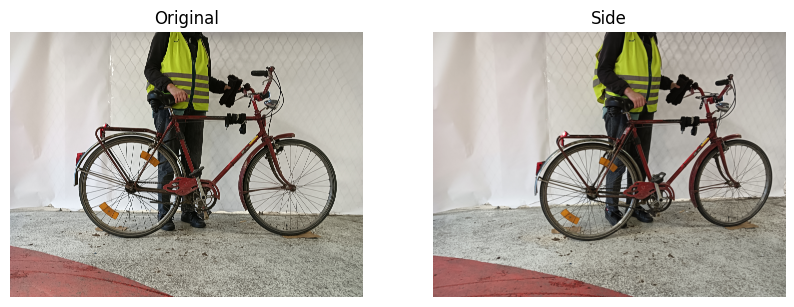

In [3]:
# Display a few pairs
def show_image_pair(orig_path, side_path):
    img_orig = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
    img_side = cv2.cvtColor(cv2.imread(side_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img_orig)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img_side)
    plt.title('Side')
    plt.axis('off')
    plt.show()

# Show first pair
for i in range(min(1, len(pairs))):
    show_image_pair(*pairs[i])



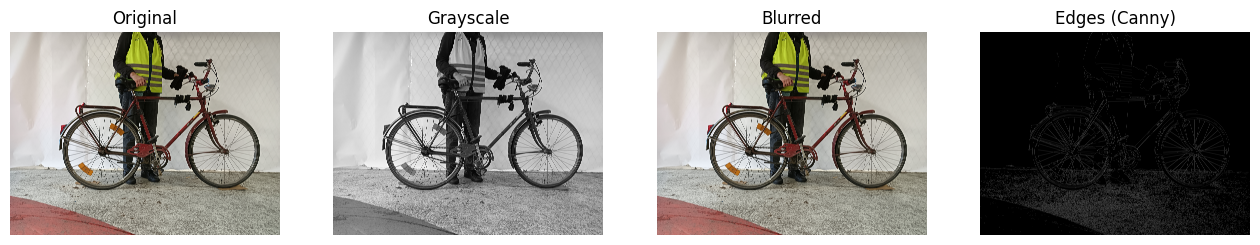

In [4]:
# OpenCV Manipulations: Grayscale, Blur, Edge Detection

# Pick a sample image (first original)
sample_img_path = pairs[0][0]
sample_img = cv2.cvtColor(cv2.imread(sample_img_path), cv2.COLOR_BGR2RGB)

# Grayscale
img_gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

# Gaussian Blur
img_blur = cv2.GaussianBlur(sample_img, (11, 11), 0)

# Edge Detection (Canny)
img_edges = cv2.Canny(img_gray, 100, 200)

# Display results
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(sample_img)
plt.title('Original')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(img_blur)
plt.title('Blurred')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(img_edges, cmap='gray')
plt.title('Edges (Canny)')
plt.axis('off')
plt.show()

# Try changing the parameters above and rerun to see different effects!


Using device: cpu


C:\Users\guill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\guill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pair 1 (distance=0.371):


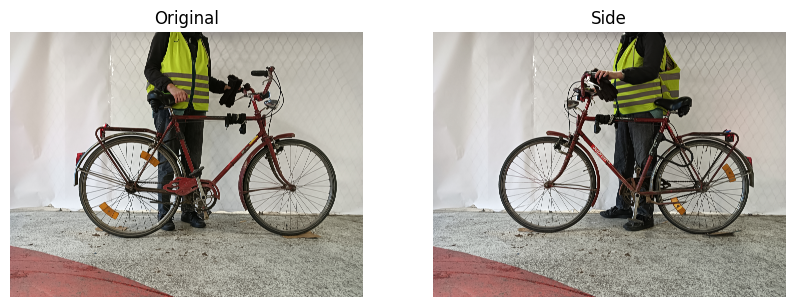

Pair 2 (distance=0.367):


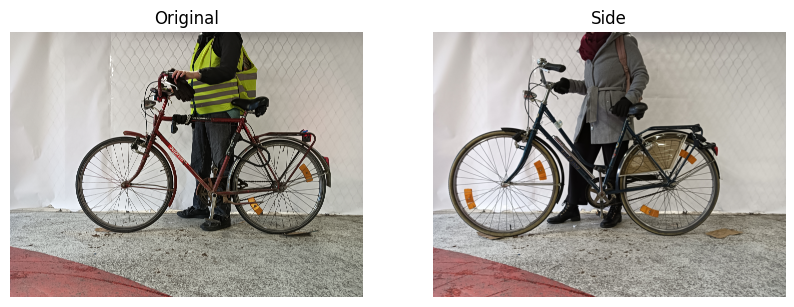

Pair 3 (distance=0.328):


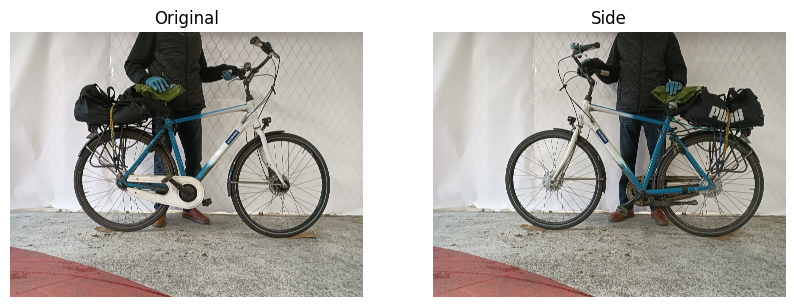

In [6]:
# Finding 'Other Face' Pairs Using Image Embeddings

# We'll use a pre-trained ResNet18 model from torchvision to compute embeddings for all images.
# For each image, we'll find its most similar 'other face' by comparing embeddings (excluding itself and its side pair).

import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
import numpy as np

# Load pre-trained ResNet18 and remove the final classification layer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = resnet18(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device)
model.eval()

# Image transform for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_embedding(img_path):
    img = Image.open(img_path).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(x).squeeze().cpu().numpy().flatten()
    return emb / np.linalg.norm(emb)

# Compute embeddings for all original images
original_imgs = sorted([os.path.join(dir_original, f) for f in os.listdir(dir_original) if f.endswith('.jpg')])
embeddings = [get_embedding(p) for p in original_imgs]

# Find best match for each image (excluding itself and its side pair)
from scipy.spatial.distance import cdist

# Build a mapping from base name to index for easy exclusion of side pairs
base_names = [os.path.basename(p).replace('-side', '').replace('.jpg', '') for p in original_imgs]

pairs_found = []
for i, emb in enumerate(embeddings):
    # Exclude itself
    mask = np.ones(len(embeddings), dtype=bool)
    mask[i] = False
    # Optionally, exclude images with the same base (e.g., if you want to avoid pairing the same bike in different views)
    # For now, just exclude itself
    dists = cdist([emb], np.array(embeddings)[mask])[0]
    best_idx = np.arange(len(embeddings))[mask][np.argmin(dists)]
    pairs_found.append((original_imgs[i], original_imgs[best_idx], dists.min()))

# Display a few best-matching pairs
for i, (img_a, img_b, dist) in enumerate(pairs_found[:3]):
    print(f"Pair {i+1} (distance={dist:.3f}):")
    show_image_pair(img_a, img_b)

# This approach can be refined to exclude true side pairs if you have a naming convention for them.


Matching features between best-matched faces (distance=0.371):


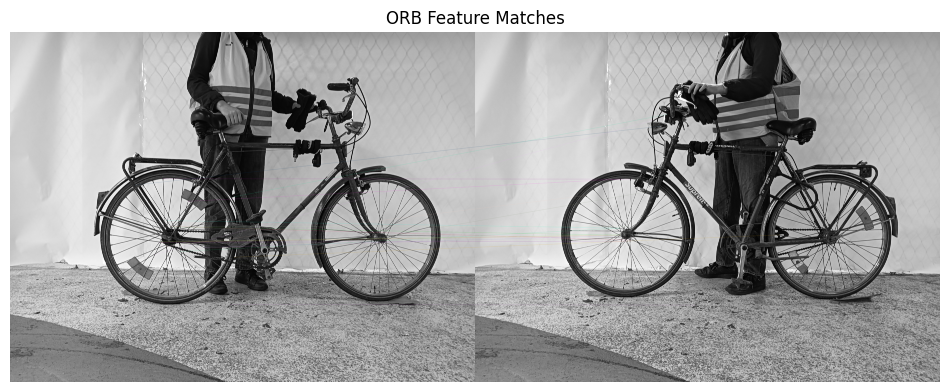

Matching features between their side views:


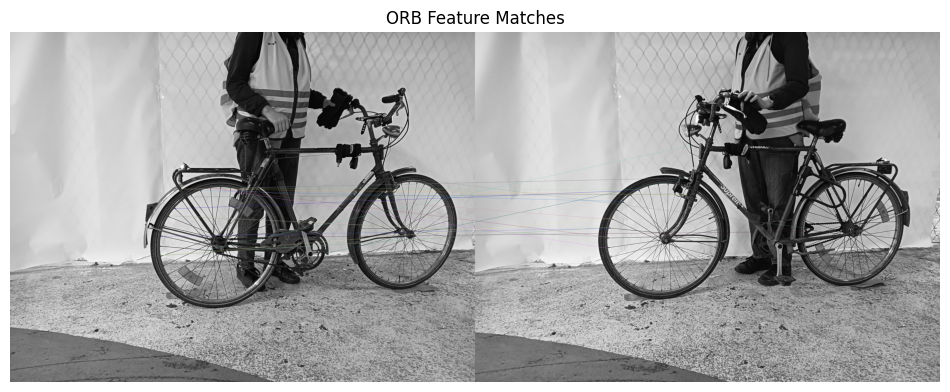

In [8]:
# Experiments: Comparing Both Faces and Their Sides

# Let's compare features between the two faces and their side views using ORB feature matching

def feature_match(img1_path, img2_path):
    img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
    plt.figure(figsize=(12,6))
    plt.imshow(img_matches, cmap='gray')
    plt.title('ORB Feature Matches')
    plt.axis('off')
    plt.show()

# Example: match the best-matched pair from the embedding experiment
if 'pairs_found' in globals() and len(pairs_found) > 0:
    best_img_a, best_img_b, best_dist = pairs_found[0]
    print(f'Matching features between best-matched faces (distance={best_dist:.3f}):')
    feature_match(best_img_a, best_img_b)
    # Try to find their side images, if available
    def get_side_path(img_path):
        base = os.path.basename(img_path)[:-4]
        side_path = os.path.join(dir_side, f"{base}-side.jpg")
        return side_path if os.path.exists(side_path) else None
    side_a = get_side_path(best_img_a)
    side_b = get_side_path(best_img_b)
    if side_a and side_b:
        print('Matching features between their side views:')
        feature_match(side_a, side_b)
    else:
        print('Side images not found for both faces.')
else:
    print('Not enough pairs to run this experiment.')


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\guill/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth


100.0%


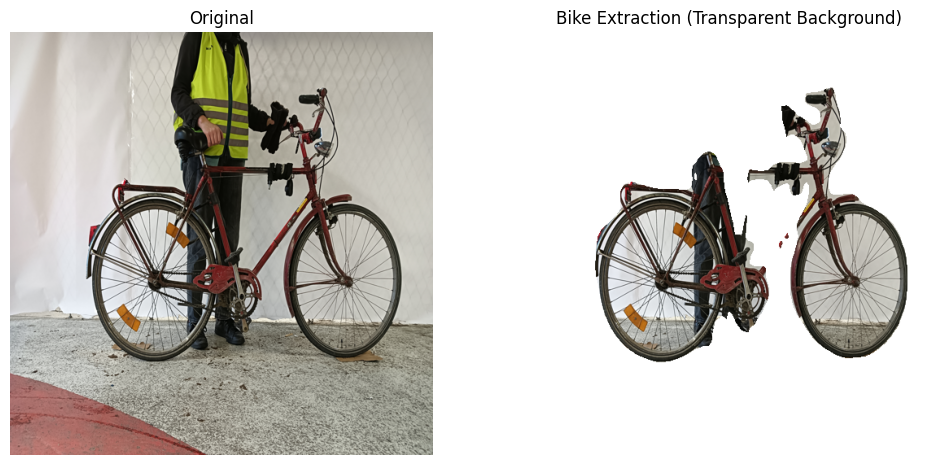

In [9]:
# Create an extraction of the bike from the image

# We'll use a pre-trained segmentation model (DeepLabV3) from torchvision to segment the image.
# This will help us extract the bike and remove the background, person, and ground.

import torchvision
from torchvision import transforms as T

# Load DeepLabV3 model
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device)
seg_model.eval()

# COCO class for bicycle is 2
BIKE_CLASS = 2

# Segmentation transform
seg_transform = T.Compose([
    T.Resize((520, 520)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_bike(img_path):
    img = Image.open(img_path).convert('RGB')
    x = seg_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = seg_model(x)['out'][0]
    mask = out.argmax(0).cpu().numpy() == BIKE_CLASS
    # Create an RGBA image with transparent background
    img_np = np.array(img.resize((520, 520)))
    result = np.zeros((520, 520, 4), dtype=np.uint8)
    result[..., :3] = img_np
    result[..., 3] = (mask * 255).astype(np.uint8)
    return result, mask

# Example: extract bike from the first image in the dataset
img_path = original_imgs[0]
extracted, mask = extract_bike(img_path)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(Image.open(img_path).resize((520, 520)))
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(extracted)
plt.title('Bike Extraction (Transparent Background)')
plt.axis('off')
plt.show()

# You can save the result with:
# Image.fromarray(extracted).save('bike_extracted.png')


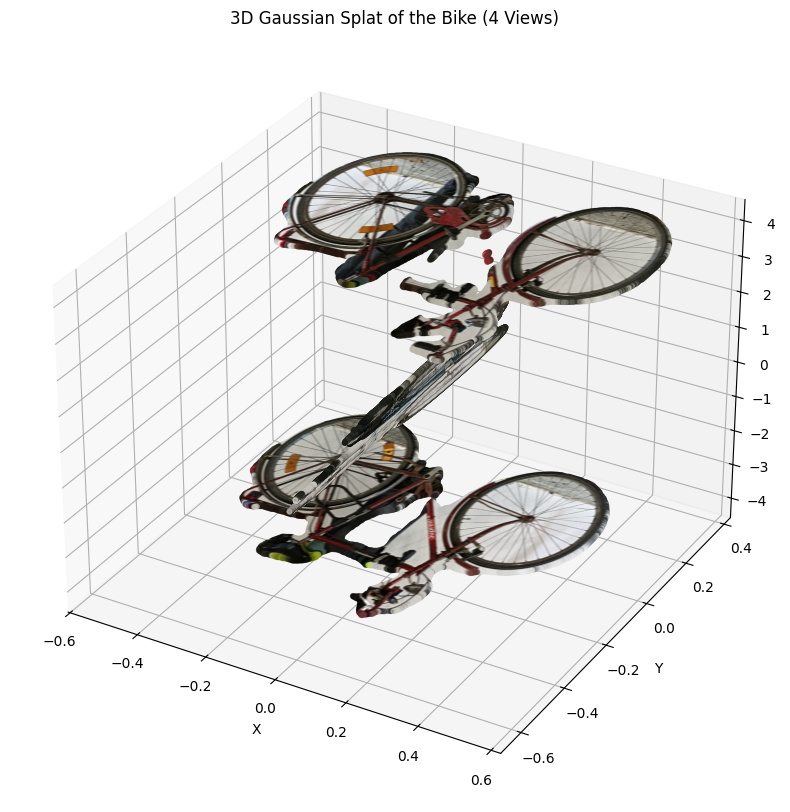

In [10]:
# 3D Gaussian Splat of the Bike from 4 Views

# We'll use 4 images (front, back, left, right) and their extracted bike masks.
# We'll make simple assumptions about camera positions and intrinsics.
# The result will be a 3D colored point cloud (splat) visualized with matplotlib.

from mpl_toolkits.mplot3d import Axes3D

# Select 4 images (for demo: first 4 original images)
img_paths = original_imgs[:4]
poses = [
    {'R': np.eye(3), 't': np.array([0, 0, 2])},      # Front
    {'R': np.array([[ -1, 0, 0], [0, 1, 0], [0, 0, -1]]), 't': np.array([0, 0, -2])}, # Back
    {'R': np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]), 't': np.array([-2, 0, 0])},   # Left
    {'R': np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]]), 't': np.array([2, 0, 0])},    # Right
]

focal_length = 800  # arbitrary
img_size = 520      # matches segmentation size
cx, cy = img_size // 2, img_size // 2

points = []
colors = []
sizes = []

for idx, (img_path, pose) in enumerate(zip(img_paths, poses)):
    extracted, mask = extract_bike(img_path)
    img = np.array(Image.open(img_path).resize((img_size, img_size)))
    ys, xs = np.where(mask)
    # Project to camera coordinates
    zs = np.ones_like(xs) * 2  # Assume all points are 2m from camera
    xs_cam = (xs - cx) * zs / focal_length
    ys_cam = (ys - cy) * zs / focal_length
    pts_cam = np.stack([xs_cam, ys_cam, zs], axis=1)
    # Transform to world coordinates
    pts_world = pts_cam @ pose['R'].T + pose['t']
    points.append(pts_world)
    colors.append(img[ys, xs] / 255.0)
    sizes.append(np.ones_like(xs) * 10)  # Gaussian splat size

points = np.concatenate(points, axis=0)
colors = np.concatenate(colors, axis=0)
sizes = np.concatenate(sizes, axis=0)

# Visualize
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=colors, s=sizes, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Gaussian Splat of the Bike (4 Views)')
plt.show()

# For a true Gaussian Splat, you would render ellipsoids/gaussians, but this scatter plot gives a similar effect for a workshop.
